<a href="https://colab.research.google.com/github/Abhinavk910/Regression/blob/master/Bigmart_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
! kaggle datasets download -d nishanta/big-mart-sales

  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 39.5MB/s]


In [0]:
! unzip -q 'big-mart-sales.zip'

In [0]:
import pandas as pd
import numpy as np

from scipy.stats import mode

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor

In [0]:
df_train = pd.read_csv('Train.csv')
print(df_train.shape)
df_train.head(2)

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [0]:
df_test = pd.read_csv('Test.csv')
print(df_test.shape)

(5681, 11)


In [0]:
df_train['source'] = 'train'
df_test['source'] = 'test'
data = pd.concat([df_train, df_test], ignore_index = True, sort = False)
data.shape

(14204, 13)

#Data Exploration

In [0]:
data.dtypes.sort_values()

Outlet_Establishment_Year      int64
Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Identifier               object
Item_Fat_Content              object
Item_Type                     object
Outlet_Identifier             object
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
source                        object
dtype: object

In [0]:
data.isnull().sum()[data.isnull().sum() != 0]

Item_Weight          2439
Outlet_Size          4016
Item_Outlet_Sales    5681
dtype: int64

In [0]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [0]:
col_to_exc = ['source', 'Item_Identifier' ]
for col in data.columns:
  if data[col].dtypes == 'O' and col not in col_to_exc:
    print(col,'\n', data[col].value_counts(), '\n')

Item_Fat_Content 
 Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64 

Item_Type 
 Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64 

Outlet_Identifier 
 OUT027    1559
OUT013    1553
OUT035    1550
OUT046    1550
OUT049    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64 

Outlet_Size 
 Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64 

Outlet_Location_Type 
 Tier 3    55

# Data Cleaning

In [0]:
item_mean_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier', aggfunc = 'mean')
miss_bool = data['Item_Weight'].isnull() 
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_mean_weight.loc[x])

In [0]:
outlet_mode_size = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc= (lambda x: mode(x).mode[0]))
miss_bool = data['Outlet_Size'].isnull() 
data.loc[miss_bool, 'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_mode_size[x])

In [0]:
data.isnull().sum()[data.isnull().sum() != 0]

Item_Outlet_Sales    5681
dtype: int64

# Feature Engineering

In [0]:
mean_visibility = data.groupby('Item_Identifier').agg({'Item_Visibility':'mean'})
miss_bool = data['Item_Visibility'] == 0
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: mean_visibility.loc[x])

In [0]:
data['Item_Visibility_Mean_Ration'] = data.apply(lambda x: x['Item_Visibility']/mean_visibility.loc[x['Item_Identifier']], axis = 1)

In [0]:
data['Item_Identifier_Type'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Identifier_Type'] = data['Item_Identifier_Type'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
data['Item_Identifier_Type'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Identifier_Type, dtype: int64

In [0]:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']

In [0]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

In [0]:
data.loc[data['Item_Identifier_Type']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [0]:
data.dtypes.sort_values()

Outlet_Establishment_Year        int64
Outlet_Years                     int64
Item_Weight                    float64
Item_Visibility                float64
Item_MRP                       float64
Item_Outlet_Sales              float64
Item_Visibility_Mean_Ration    float64
Item_Identifier                 object
Item_Fat_Content                object
Item_Type                       object
Outlet_Identifier               object
Outlet_Size                     object
Outlet_Location_Type            object
Outlet_Type                     object
source                          object
Item_Identifier_Type            object
dtype: object

In [0]:
data['Outlet'] = data['Outlet_Identifier']
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Identifier_Type',
                                     'Outlet'])

In [0]:
data.dtypes.sort_values()

Outlet_Size_Medium                       uint8
Outlet_Type_Grocery Store                uint8
Outlet_Type_Supermarket Type1            uint8
Outlet_Type_Supermarket Type2            uint8
Outlet_Type_Supermarket Type3            uint8
Item_Identifier_Type_Drinks              uint8
Item_Identifier_Type_Food                uint8
Item_Identifier_Type_Non-Consumable      uint8
Outlet_OUT010                            uint8
Outlet_OUT013                            uint8
Outlet_OUT017                            uint8
Outlet_OUT018                            uint8
Outlet_OUT019                            uint8
Outlet_OUT027                            uint8
Outlet_OUT035                            uint8
Outlet_OUT045                            uint8
Outlet_Size_Small                        uint8
Outlet_OUT046                            uint8
Outlet_OUT049                            uint8
Outlet_Location_Type_Tier 3              uint8
Outlet_Location_Type_Tier 2              uint8
Outlet_Locati

In [0]:
data.drop(['Item_Type','Outlet_Establishment_Year'], axis = 1, inplace = True)

In [0]:
train = data.loc[data['source'] == "train"]
test = data.loc[data['source'] == "test"]
train.shape, test.shape

((8523, 35), (5681, 35))

In [0]:
train.drop(['source'], axis = 1, inplace = True)
test.drop(['Item_Outlet_Sales','source'], axis = 1, inplace = True)
train.shape, test.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


((8523, 34), (5681, 33))

# Model Preparation


In [0]:
target = 'Item_Outlet_Sales'
ID_Col = ['Item_Identifier', 'Outlet_Identifier']
Col_used = [col for col in test.columns if col not in ID_Col and target]

In [0]:
def modelfit(model, dtrain = train, Target = target, Identity_column = ID_Col, Column_used = Col_used):
  
  model.fit(dtrain[Column_used], dtrain[Target])
  y_pred = model.predict(dtrain[Column_used])
  
  cv_score = cross_val_score(model, dtrain[Column_used], dtrain[Target], cv = 10, scoring = 'neg_mean_squared_error')
  cv_score = np.sqrt(np.abs(cv_score))
  
  print('RSME : %0.4f'% np.sqrt(mean_squared_error(dtrain[Target], y_pred)))
  print('CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g' % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

RSME : 1127.3799
CV Score : Mean - 1130 | Std - 16.29 | Min - 1110 | Max - 1163


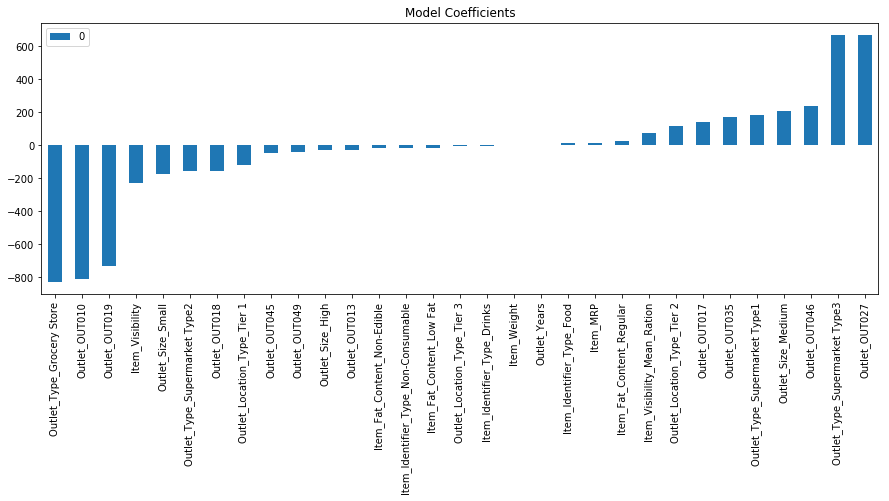

In [0]:
model1 = LinearRegression(normalize=True)
modelfit(model1)
pd.DataFrame(data = np.transpose(model1.coef_), index = Col_used).sort_values([0]).plot(kind='bar', title='Model Coefficients', figsize = (15,5))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

RSME : 1273.8589
CV Score : Mean - 1270 | Std - 33.98 | Min - 1209 | Max - 1340


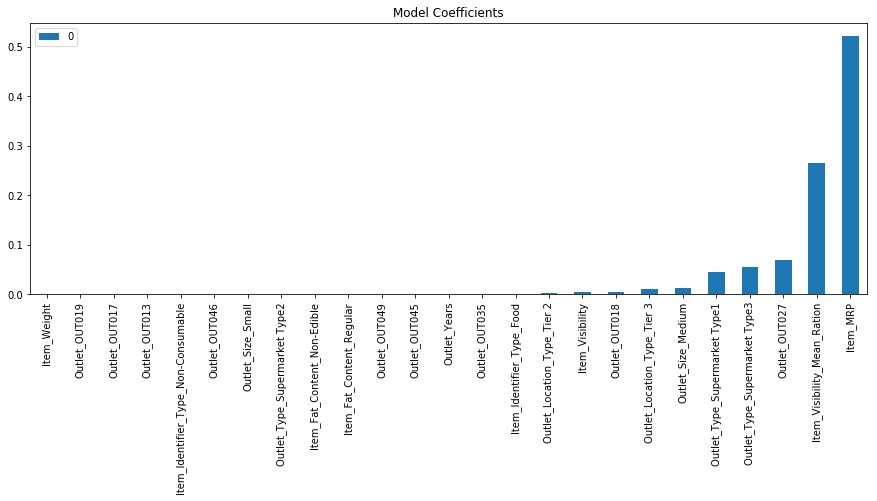

In [0]:
# parameters = {
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 3),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 3),
#     "max_depth":[3,5],
#     "max_features":["log2","sqrt"],
#     "n_estimators":[5,10]
#     }

# clf = GridSearchCV(GradientBoostingRegressor(random_state = 42), parameters, cv=10, n_jobs=-1, scoring = 'neg_mean_squared_error', verbose = 1)

# clf.fit(train[Col_used], train[target])
# print(clf.score(train[Col_used], train[target]))
# print(clf.best_params_)




model2 = GradientBoostingRegressor(learning_rate =0.2, max_depth= 3, max_features= 'sqrt', min_samples_leaf= 0.1,
                                   min_samples_split =  0.34, n_estimators =  10, random_state = 42)
modelfit(model2)
pd.DataFrame(data = np.transpose(model2.feature_importances_), index = Col_used).sort_values([0]).plot(kind='bar', title='Model Coefficients', figsize = (15,5))

[20:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

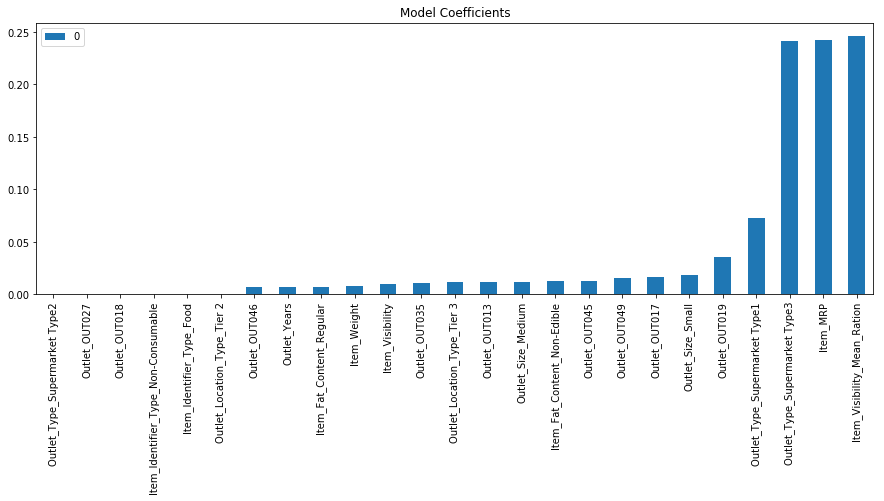

In [0]:
from xgboost import XGBRegressor
model3 = XGBRegressor()
modelfit(model3)
pd.DataFrame(data = np.transpose(model3.feature_importances_), index = Col_used).sort_values([0]).plot(kind='bar', title='Model Coefficients', figsize = (15,5))

In [0]:
model3 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.01,0.03], #so called `eta` value
              'max_depth': [2, 3, 5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(model3,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=1)
xgb_grid.fit(train[Col_used], train[target])
print(np.sqrt(mean_squared_error(train[target],xgb_grid.predict(train[Col_used]))))
print(xgb_grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   46.4s finished


{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [0]:
np.sqrt(mean_squared_error(train[target],xgb_grid.predict(train[Col_used])))

1059.7635172727266

RSME : 910.4498
CV Score : Mean - 1102 | Std - 18.42 | Min - 1070 | Max - 1128


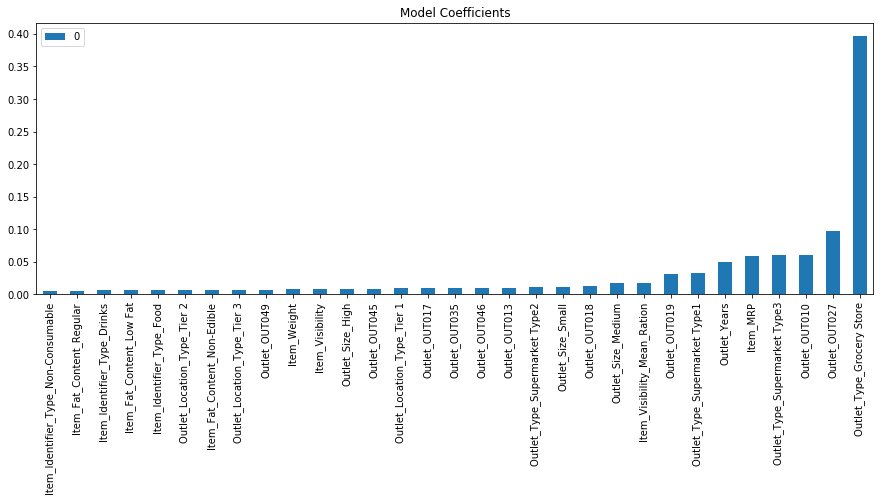

In [0]:
model3 = XGBRegressor(max_depth = 5, n_estimators = 500, colsample_bytree = 0.7, learning_rate = 0.03, min_child_weight = 4, nthread = 4,
                      objective = 'reg:linear', silent = 1, subsample = 0.7)
modelfit(model3)
pd.DataFrame(data = np.transpose(model3.feature_importances_), index = Col_used).sort_values([0]).plot(kind='bar', title='Model Coefficients', figsize = (15,5))

In [0]:
! pip install eli5

[Permutation importance](https://www.kaggle.com/dansbecker/permutation-importance)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model3, random_state=1).fit(train[Col_used], train[target])
eli5.show_weights(perm, feature_names = train[Col_used].columns.tolist())

Weight,Feature
0.7890 ± 0.0182,Item_MRP
0.2644 ± 0.0065,Outlet_Type_Grocery Store
0.0439 ± 0.0056,Outlet_Years
0.0371 ± 0.0029,Item_Visibility_Mean_Ration
0.0366 ± 0.0018,Item_Visibility
0.0325 ± 0.0012,Item_Weight
0.0277 ± 0.0038,Outlet_Type_Supermarket Type3
0.0107 ± 0.0012,Outlet_OUT027
0.0092 ± 0.0018,Outlet_Type_Supermarket Type1
0.0031 ± 0.0005,Outlet_OUT035


In [0]:
! pip install pdpbox

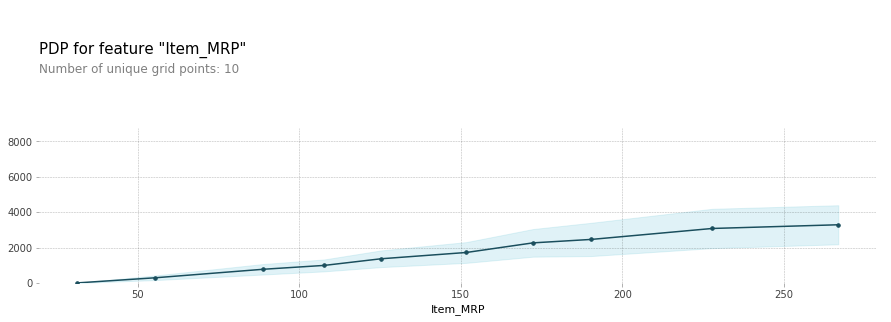

In [0]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots


pdp_goals = pdp.pdp_isolate(model=model3, dataset=train[Col_used], model_features=Col_used, feature='Item_MRP')
pdp.pdp_plot(pdp_goals, 'Item_MRP', figsize = (15,5))
plt.show()

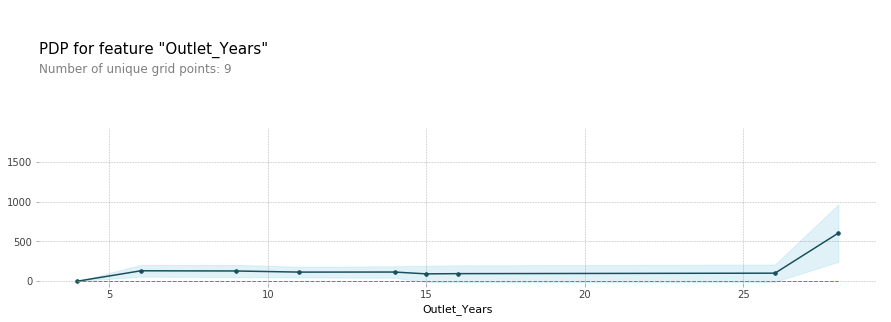

In [0]:
feature_to_plot = 'Outlet_Years'
pdp_dist = pdp.pdp_isolate(model=model3, dataset=train[Col_used], model_features=Col_used, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot, figsize=(15,5))
plt.show()

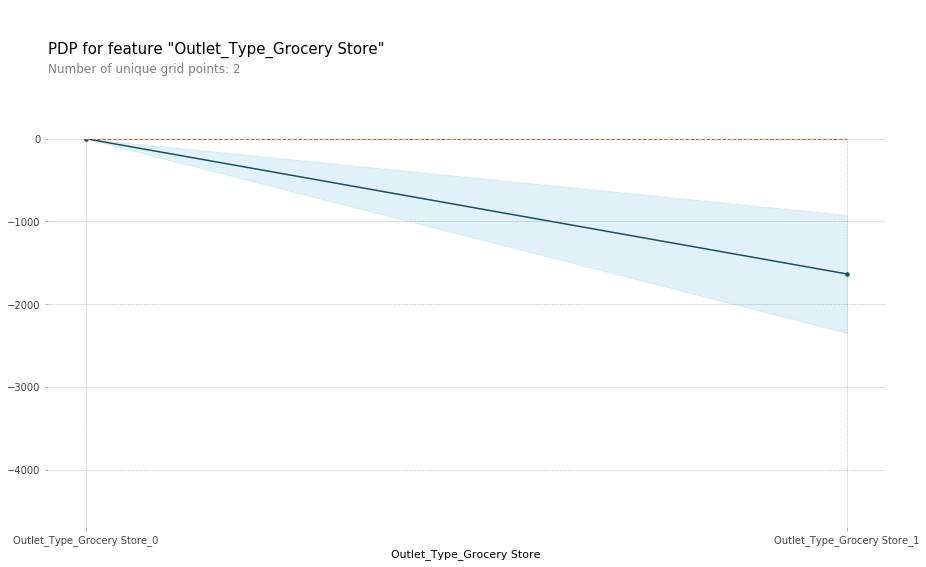

In [0]:
feature_to_plot = 'Outlet_Type_Grocery Store'
pdp_dist = pdp.pdp_isolate(model=model3, dataset=train[Col_used], model_features=Col_used, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

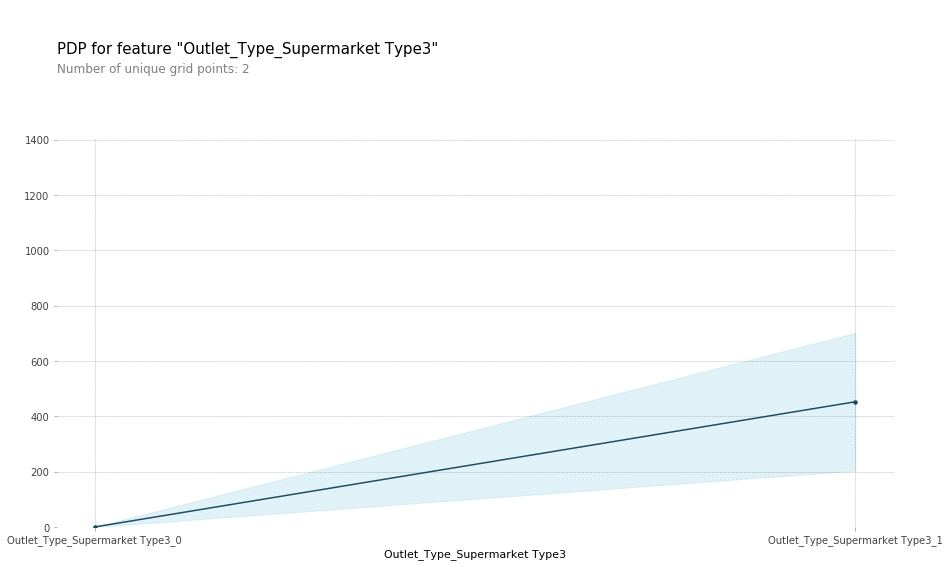

In [0]:
feature_to_plot = 'Outlet_Type_Supermarket Type3'
pdp_dist = pdp.pdp_isolate(model=model3, dataset=train[Col_used], model_features=Col_used, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

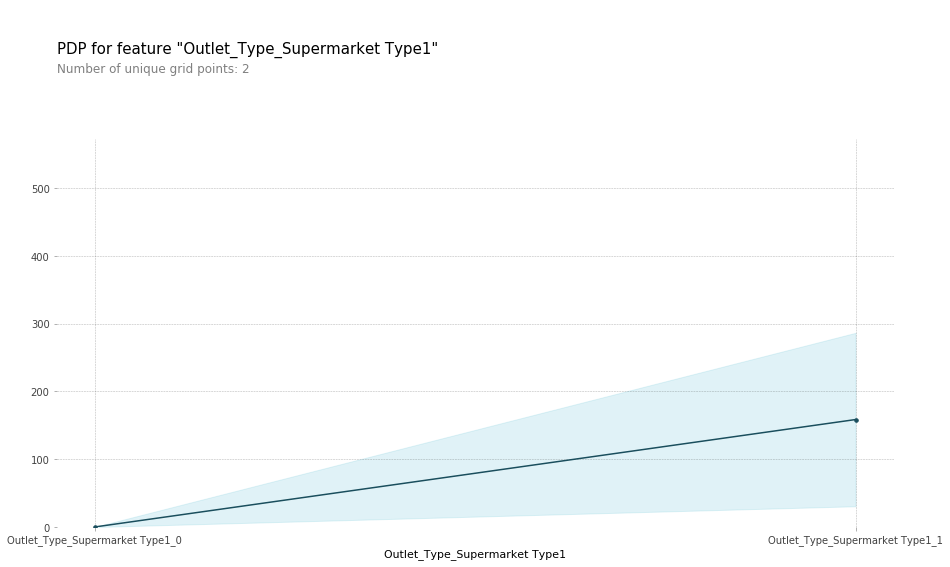

In [0]:
feature_to_plot = 'Outlet_Type_Supermarket Type1'
pdp_dist = pdp.pdp_isolate(model=model3, dataset=train[Col_used], model_features=Col_used, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

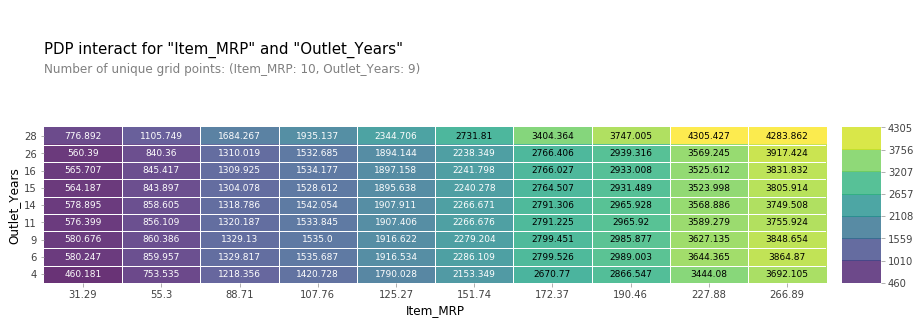

In [0]:
features_to_plot = ['Item_MRP', 'Outlet_Years']
inter1  =  pdp.pdp_interact(model=model3, dataset=train[Col_used], model_features=Col_used, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot,plot_type = 'grid', figsize = (15,5))
plt.show()